In [3]:
!pip install tensorflow==2.15.0

In [4]:
!pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_s

In [5]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [6]:
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow.keras import layers
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:5000]  # Use only the first 5000 samples for faster training

# Normalize images to [-1, 1]
x_train = (x_train - 127.5) / 127.5
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype(np.float32)

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
# Quantum Circuit Creation with Symbolic Parameters
def create_quantum_circuit(qubits, symbols):
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.H(qubit)  # Apply Hadamard gate
    circuit += cirq.CNOT(qubits[0], qubits[1])
    circuit += cirq.ry(symbols[0])(qubits[0])  # Apply parameterized rotation
    return circuit

In [8]:
# Quantum Generator Model
def build_quantum_generator():
    qubits = cirq.GridQubit.rect(1, 2)  # Using 2 qubits for simplicity

    # Define symbolic parameters
    symbols = [sympy.Symbol(f'θ{i}') for i in range(1)]

    # Create a Cirq circuit with symbolic parameters
    quantum_circuit = create_quantum_circuit(qubits, symbols)

    # Prepare input and quantum layer
    circuit_input = layers.Input(shape=(), dtype=tf.dtypes.string)
    quantum_layer = tfq.layers.PQC(quantum_circuit, cirq.Z(qubits[-1]))(circuit_input)

    # Classical network to map quantum output to an image
    classical_model = tf.keras.Sequential([
        layers.Input(shape=(1,)),  # Single input (quantum layer)
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])

    generator_output = classical_model(quantum_layer)
    return tf.keras.Model(inputs=circuit_input, outputs=generator_output)

In [9]:
# Discriminator Model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
# Compile QGAN
def compile_qgan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    discriminator.trainable = False

    gan_input = layers.Input(shape=(), dtype=tf.dtypes.string)  # Input shape as () for a single circuit
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    qgan = tf.keras.Model(gan_input, gan_output)
    qgan.compile(optimizer='adam', loss='binary_crossentropy')
    return qgan

In [11]:
# Visualization Function
def visualize_generated_images(generator, epoch, n=5):
    random_circuits = tfq.convert_to_tensor([
        create_quantum_circuit(cirq.GridQubit.rect(1, 2), [np.random.uniform(0, 2 * np.pi)])
        for _ in range(n)
    ])

    generated_images = generator.predict(random_circuits)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

In [12]:
# Training QGAN
def train_qgan(generator, discriminator, qgan, epochs, batch_size, data):
    d_loss_real_list = []
    d_loss_fake_list = []
    g_loss_list = []

    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data = data[idx]
        real_labels = np.ones((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)

        # Create random circuits for fake data generation
        random_circuits = tfq.convert_to_tensor([
            create_quantum_circuit(cirq.GridQubit.rect(1, 2), [np.random.uniform(0, 2 * np.pi)])
            for _ in range(batch_size)
        ])
        fake_data = generator.predict(random_circuits)
        fake_labels = np.zeros((batch_size, 1))

        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)

        g_loss = qgan.train_on_batch(random_circuits, real_labels)

        d_loss_real_list.append(d_loss_real[0])
        d_loss_fake_list.append(d_loss_fake[0])
        g_loss_list.append(g_loss)

        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Discriminator Loss Real: {d_loss_real[0]}, Fake: {d_loss_fake[0]} | Generator Loss: {g_loss}")
            visualize_generated_images(generator, epoch)

    return d_loss_real_list, d_loss_fake_list, g_loss_list

1/1 [==============================] - 0s 144ms/step
Epoch 0 | Discriminator Loss Real: 1.045485019683838, Fake: 0.7281924486160278 | Generator Loss: 0.6635288000106812
1/1 [==============================] - 0s 135ms/step


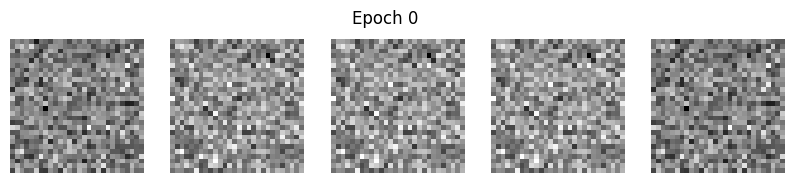

1/1 [==============================] - 0s 17ms/step
Epoch 1000 | Discriminator Loss Real: 0.0004727393970824778, Fake: 0.0014600396389141679 | Generator Loss: 6.718648910522461
1/1 [==============================] - 0s 23ms/step


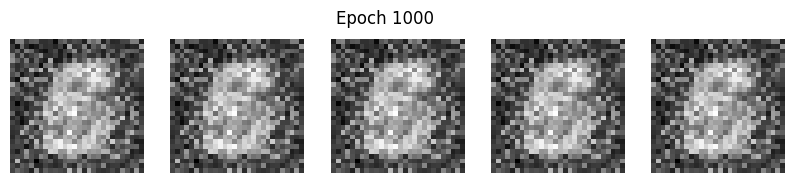

1/1 [==============================] - 0s 23ms/step
Epoch 2000 | Discriminator Loss Real: 6.298444532149006e-06, Fake: 0.0005495154764503241 | Generator Loss: 7.468613624572754
1/1 [==============================] - 0s 19ms/step


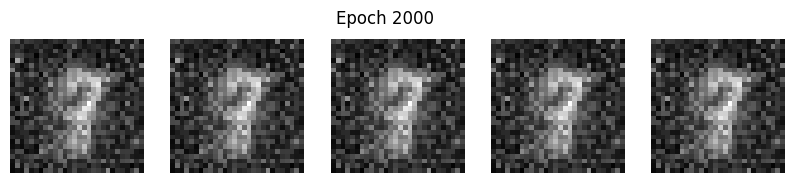

1/1 [==============================] - 0s 19ms/step
Epoch 3000 | Discriminator Loss Real: 2.321394276805222e-06, Fake: 0.005145478527992964 | Generator Loss: 5.026298999786377
1/1 [==============================] - 0s 21ms/step


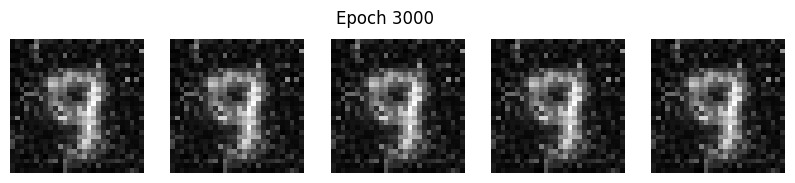

1/1 [==============================] - 0s 20ms/step
Epoch 4000 | Discriminator Loss Real: 2.707520479816594e-06, Fake: 0.0006365729495882988 | Generator Loss: 7.437843322753906
1/1 [==============================] - 0s 22ms/step


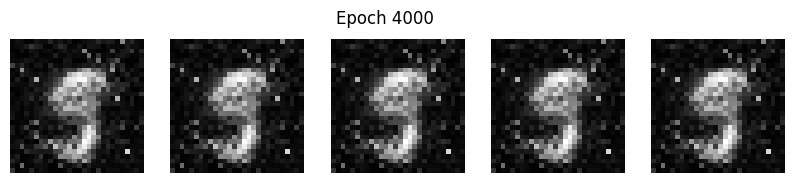

1/1 [==============================] - 0s 20ms/step


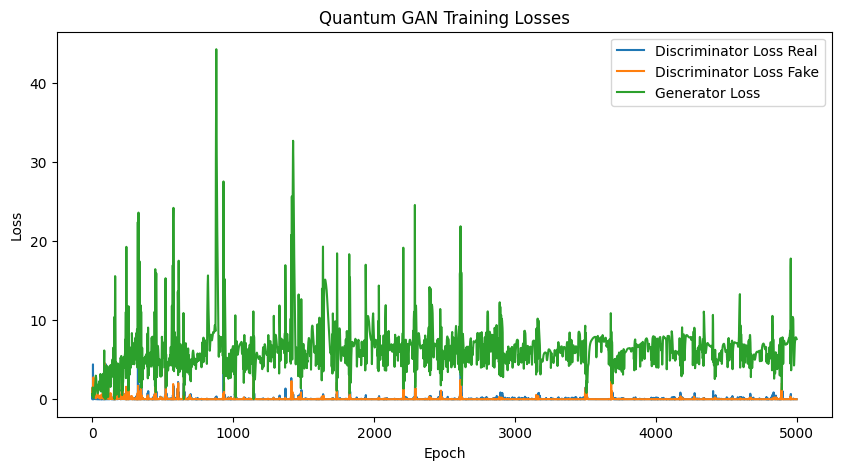

In [ ]:
# Initialize and train QGAN
generator = build_quantum_generator()
discriminator = build_discriminator()
qgan = compile_qgan(generator, discriminator)

# Train the Quantum GAN
d_loss_real_list, d_loss_fake_list, g_loss_list = train_qgan(generator, discriminator, qgan, epochs=5000, batch_size=32, data=x_train)

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(d_loss_real_list, label='Discriminator Loss Real')
plt.plot(d_loss_fake_list, label='Discriminator Loss Fake')
plt.plot(g_loss_list, label='Generator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Quantum GAN Training Losses')
plt.show()